# Research Challenge

```{admonition} Margaret Atwood
:class: tip
Every aspect of human technology has a dark side, including the bow and arrow
```

## 🏅 Build your own model 

You have been assigned one dataset from [MatBench](https://matbench.materialsproject.org) as introduced in the [Lecture slides](https://speakerdeck.com/aronwalsh/mlformaterials-lecture9-challenge). You are free to choose and tune any machine-learning model, with any Python library, but it should be appropriate for the problem. For instance, [XGBoost](https://xgboost.readthedocs.io) could be a good starting starting point to build a regression model. You can refer back to earlier notebooks and repurpose code as needed. 

You may reach the limits of computing processing power on Google Colab. Building a useful model with limited resources is a real-world skill. Using other free resources is allowed if you find an alternative service, as is running on your own computer. A model tracker such as [wandb](https://wandb.ai) could be helpful for advanced users. If you want to try a brute force approach, a library such as [Automatminer](https://hackingmaterials.lbl.gov/automatminer) may be of interest.

This notebook should be used for keeping a record of your model development, submission, and even your presentation. You are free to edit (add/remove/delete) or rearrange the cells as you see fit.

### Your details

In [27]:
import numpy as np

# Insert your values
Name = "Abhi Rajendran" # Replace with your name
CID = 1712516 # Replace with your College ID (as a numeric value with no leading 0s)

# Set a random seed using the CID value
CID = int(CID)
np.random.seed(CID)

# Print the message
print("This is the work of " + Name + " [CID: " + str(CID) + "]")

# suppress warnings for whole notebook
import warnings
warnings.filterwarnings("ignore")

This is the work of Abhi Rajendran [CID: 1712516]


## Problem statement

You have been assigned one dataset from the [list](https://matbench.materialsproject.org/Benchmark%20Info/matbench_v0.1/) on [MatBench](https://matbench.materialsproject.org). You should state what problem you are trying to solve and comment on the best-performing model in the benchmark. 

We are performing classification on the matbench_glass dataset. The target variable is 'gfa' which is a binary variable. 1 means glass forming and corresponds to amorphous, 0 means non full glass forming.

The top three performing models are listed in the table below,

| algorithm     | mean rocauc | std rocauc | mean f1 | mean balanced_accuracy |
|---------------|-------------|------------|---------|------------------------|
| MODNet (v0.1.12) | 0.9603      | 0.0075     | 0.9784  | 0.9603                 |
| AMMExpress v2020 | 0.8607      | 0.0199     | 0.9043  | 0.8607                 |
| RF-SCM/Magpie | 0.8587      | 0.0158     | 0.9278  | 0.8587                 |


## Data preparation

Check the data distribution and apply appropriate pre-processing steps as required.

In [2]:
# Get dataset info from matminer
from matminer.datasets import get_all_dataset_info
from matminer.datasets import load_dataset

  # D (GTA - Yifan)
info = get_all_dataset_info("matbench_glass")

# Check out the info about the dataset.
print(info)

Dataset: matbench_glass
Description: Matbench v0.1 test dataset for predicting full bulk metallic glass formation ability from chemical formula. Retrieved from "Nonequilibrium Phase Diagrams of Ternary Amorphous Alloys,’ a volume of the Landolt– Börnstein collection. Deduplicated according to composition, ensuring no compositions were reported as both GFA and not GFA (i.e., all reports agreed on the classification designation). For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	composition: Chemical formula.
	gfa: Target variable. Glass forming ability: 1 means glass forming and corresponds to amorphous, 0 means non full glass forming.
Num Entries: 5680
Reference: Y. Kawazoe, T. Masumoto, A.-P. Tsai, J.-Z. Yu, T. Aihara Jr. (1997) Y. Kawazoe, J.-Z. Yu, A.-P. Tsai, T. Masumoto (ed.) SpringerMaterials
Nonequilibrium Phase Diagrams of Ternary Amorphous All

In [3]:
# module imports 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset into a pandas DataFrame
df = load_dataset("matbench_glass")
raw_data = df.copy()  # Keep a copy of the raw data
df


Reading file /opt/anaconda3/envs/glasses_classes/lib/python3.10/site-packages/matminer/datasets/matbench_glass.json.gz: 0it [00:00, ?it/s]0, ?it/s]


,composition,gfa
0,Al,False
1,Al(NiB)2,True
2,Al10Co21B19,True
3,Al10Co23B17,True
4,Al10Co27B13,True
...,...,...
5675,ZrTi9,False
5676,ZrTiSi2,True
5677,ZrTiSi3,True
5678,ZrVCo8,True


In [4]:
df.describe() # Summary statistics

,composition,gfa
count,5680,5680
unique,5680,2
top,Al,True
freq,1,4035


Decoding objects from /opt/anaconda3/envs/glasses_classes/lib/python3.10/site-packages/matminer/datasets/matbench_glass.json.gz: 0it [00:00, ?it/s]


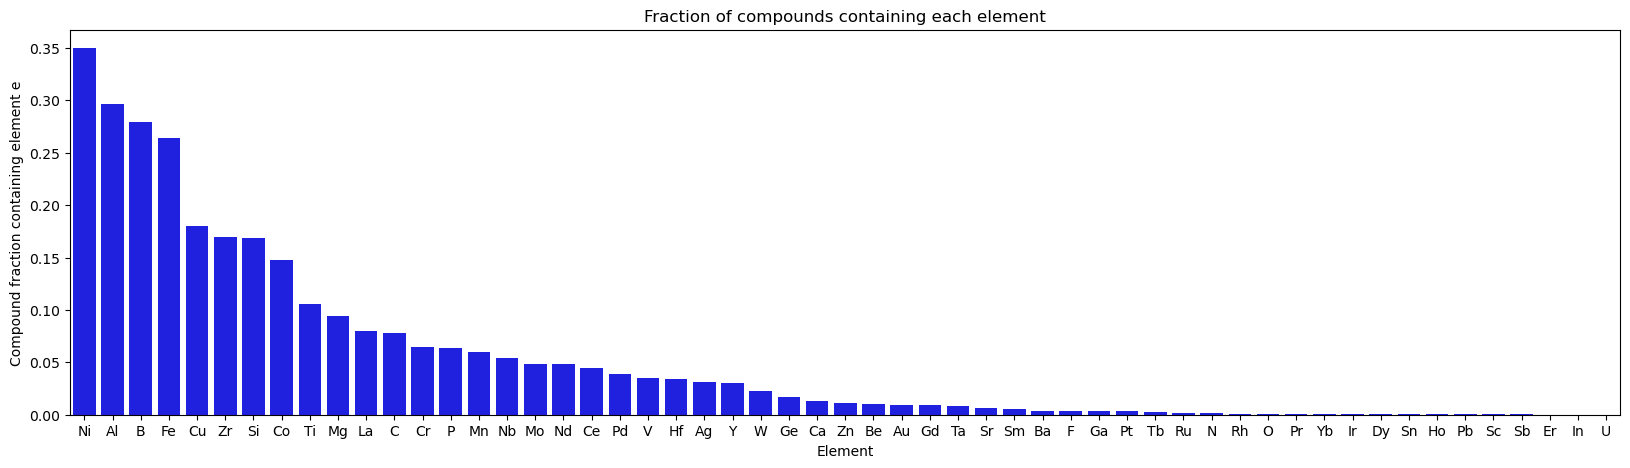

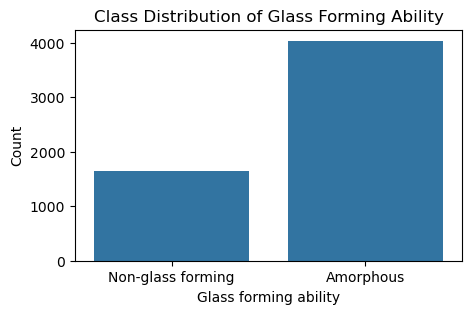

In [5]:
import matplotlib.pyplot as plt
from pymatgen.core import Composition
from collections import defaultdict


def plot_element_fractions(df): # Function to plot the fraction of compounds containing each element
    df = df.copy(deep=True)

    # Convert the 'composition' column from string to pymatgen Composition objects
    df["composition"] = df["composition"].map(Composition)

    # Apply a lambda function to 'composition' to get a dictionary of element amounts
    values = df["composition"].apply(lambda s: s.get_el_amt_dict())
    
    # Initialize dictionaries to store elements and their proportions
    elements = defaultdict(float)
    proportions = defaultdict(list)
    
    # Iterate over each composition to calculate total amounts and proportions
    for s in values:
        tot = np.sum(list(s.values())) 
        for e in s:  
            elements[e] += 1 
            proportions[e] += [s[e]/tot] 

    # Calculate the frequency of each element as a fraction of total compositions
    for elem in elements:
        elements[elem] /= len(values)

    # Calculate the mean proportion of each element
    mean_proportions = {elem: np.mean(proportions[elem]) for elem in proportions}
    mean_proportions = dict(sorted(mean_proportions.items(), key=lambda x: x[1], reverse=True))
    elements = dict(sorted(elements.items(), key=lambda x: x[1], reverse=True))
    elements_df = pd.DataFrame(list(elements.items()), columns=['Element', 'Fraction'])

    # Create the plot
    plt.figure(figsize=(20,5))
    sns.barplot(x='Element', y='Fraction', data=elements_df, color='b')
    plt.ylabel('Compound fraction containing element e')
    plt.title('Fraction of compounds containing each element')
    plt.show()


def plot_gfa(df): 
    # Create a bar plot of the 'gfa' column to show the distribution of glass forming ability
    plt.figure(figsize=(5, 3))
    sns.countplot(x='gfa', data=df)
    plt.xlabel('Glass forming ability')
    plt.xticks([0, 1], ['Non-glass forming', 'Amorphous'])
    plt.ylabel('Count')
    plt.title('Class Distribution of Glass Forming Ability')
    plt.show()

plot_element_fractions(raw_data)
plot_gfa(raw_data)


In [30]:
from matminer.featurizers.composition.composite import ElementProperty
from pymatgen.core import Composition
from sklearn.preprocessing import MinMaxScaler
from elementembeddings.composition import composition_featuriser

class DataProcessor:
    """
    A class that provides methods for data processing and featurization.

    Args:
        embedding (str): The embedding to be used for composition featurization.

    Attributes:
        embedding (str): The embedding used for composition featurization.
        featuriser (ElementProperty): The featurizer object for element properties.

    Methods:
        featurise_composition: Featurizes the composition column using one-hot encoding.
        featurise_with_pymatgen: Featurizes the composition column using pymatgen.
        scale_data: Scales the numerical columns in the dataframe.

    """

    def __init__(self, embedding):
        self.embedding = embedding
        self.featuriser = ElementProperty.from_preset(preset_name='magpie')
        self.featuriser.set_n_jobs(1)
    
    def featurise_composition(self, df):
        """
        Featurizes the composition column of the dataframe using one-hot encoding.

        Args:
            df (pandas.DataFrame): The input dataframe.

        Returns:
            pandas.DataFrame: The featurized dataframe.

        """
    
        df = df.copy(deep=True)

        print(f"Using {self.embedding} embedding for composition featurisation.")
        
        onehot_df = composition_featuriser(df["composition"], embedding=self.embedding, stats=["mean"])
        onehot_df.drop(columns=['formula'], inplace=True)  # Drop the original composition column

        #add gfa column to the onehot_df
        onehot_df['gfa'] = df['gfa'].astype(int)
        
        return onehot_df
    
    def featurise_with_pymatgen(self, df, col_id='composition'):
        """
        Featurizes the composition column of the dataframe using pymatgen.

        Args:
            df (pandas.DataFrame): The input dataframe.
            col_id (str): The name of the composition column.

        Returns: 
            pandas.DataFrame: The featurized dataframe.

        """

        df = df.copy(deep=True)
        print(f"Featurising the composition column using pymatgen.")

        df["composition_pmg"] = df[col_id].map(Composition)
        df_pmg = self.featuriser.featurize_dataframe(df, col_id='composition_pmg')

        return df_pmg
    
    def scale_data(self, df):
        """
        Scale the numerical columns in the given DataFrame.

        Parameters:
        - df (pandas.DataFrame): The DataFrame containing the data to be scaled.

        Returns:
        - df (pandas.DataFrame): The DataFrame with the scaled numerical columns.
        """

        df = df.copy(deep=True)
        print("Scaling the numerical columns.")

        # Get the numerical columns to scale
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

        # Scale the data
        scaler = MinMaxScaler()
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

        return df

In [ ]:
data_processor = DataProcessor(embedding="atomic") #can be changed to atomic or magpie
one_hot_data = data_processor.featurise_composition(raw_data)
one_hot_scaled_data = data_processor.scale_data(one_hot_data)

one_hot_scaled_data

In [32]:
data_processor = DataProcessor(embedding="magpie") #can be changed to atomic or magpie
featurised_data = data_processor.featurise_with_pymatgen(raw_data)
scaled_data = data_processor.scale_data(featurised_data)
processed_data = scaled_data.copy()

processed_data

Featurising the composition column using pymatgen.


ElementProperty: 100%|██████████| 5680/5680 [00:11<00:00, 487.28it/s]


Scaling the numerical columns.


,composition,gfa,composition_pmg,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,Al,False,(Al),0.150000,0.0125,0.000000,0.072975,0.000000,0.120000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.991111,0.885714,0.000000,0.960342,0.000000,0.936508
1,Al(NiB)2,True,"(Al, Ni, B)",0.016667,0.2000,0.294872,0.115235,0.299240,0.013333,0.818182,...,0.282089,0.118423,0.270805,0.000000,0.728889,0.885714,0.259912,0.707386,0.275832,0.000000
2,Al10Co21B19,True,"(Al, Co, B)",0.016667,0.1875,0.282051,0.115839,0.287417,0.306667,0.772727,...,0.733642,0.323387,0.714861,0.733642,0.728889,0.885714,0.259912,0.580480,0.174397,0.444444
3,Al10Co23B17,True,"(Al, Co, B)",0.016667,0.1875,0.282051,0.129120,0.289968,0.306667,0.772727,...,0.733642,0.354186,0.728947,0.733642,0.728889,0.885714,0.259912,0.592484,0.163458,0.444444
4,Al10Co27B13,True,"(Al, Co, B)",0.016667,0.1875,0.282051,0.155684,0.282119,0.306667,0.772727,...,0.733642,0.415783,0.728947,0.733642,0.728889,0.885714,0.259912,0.616494,0.136342,0.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5675,ZrTi9,False,"(Zr, Ti)",0.300000,0.3500,0.230769,0.235979,0.099338,0.240000,0.545455,...,0.000011,0.000010,0.000004,0.000011,0.853333,0.000000,0.000000,0.628069,0.000000,0.444444
5676,ZrTiSi2,True,"(Zr, Ti, Si)",0.166667,0.3500,0.333333,0.216358,0.268273,0.133333,0.545455,...,0.000011,0.000003,0.000008,0.000000,0.853333,0.942857,0.145374,0.804924,0.160707,0.968254
5677,ZrTiSi3,True,"(Zr, Ti, Si)",0.166667,0.3500,0.333333,0.190700,0.250184,0.133333,0.545455,...,0.000011,0.000002,0.000007,0.000000,0.853333,0.942857,0.145374,0.840295,0.154279,0.968254
5678,ZrVCo8,True,"(Zr, V, Co)",0.316667,0.3500,0.217949,0.297860,0.074197,0.306667,0.560606,...,0.733642,0.615975,0.469531,0.733642,0.853333,1.000000,0.154185,0.665584,0.061361,0.444444


## Model choice 

Define your model and justify your choice based on the problem and available data. You can look back at earlier notebooks and investigate other examples online.

In [72]:
# Model Selection and Evaluation
from sklearn.model_selection import cross_validate  # Cross-validation
from sklearn.model_selection import KFold, StratifiedKFold  # K-Fold CV
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit  # ShuffleSplit CV
from sklearn.model_selection import train_test_split  # Split arrays or matrices into random train and test subsets
from sklearn.metrics import accuracy_score  # Accuracy classification score
from sklearn.metrics import confusion_matrix  # Compute confusion matrix to evaluate accuracy of a classification

# Machine Learning Models
from sklearn.linear_model import LogisticRegression, SGDClassifier  # Linear models for classification
from sklearn.svm import SVC  # C-Support Vector Classification
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Ensemble methods
from sklearn.neighbors import KNeighborsClassifier  # Classifier implementing the k-nearest neighbors vote
from sklearn.tree import DecisionTreeClassifier  # Decision Tree Classifier
from sklearn.neural_network import MLPClassifier  # Multi-layer Perceptron classifier
from xgboost import XGBClassifier  # Gradient Boosting for classification from XGBoost library

# create a list of models
models = [
    LogisticRegression(),
    SVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    XGBClassifier(),
    SGDClassifier(),
    GradientBoostingClassifier(),
    MLPClassifier(),  # Neural network classifier
]

#scoring metric list
scoring_list = ["accuracy", "roc_auc", "f1"]

# create a function to perform cross validation
def cross_validate_models(models, X, y, cv=5):
    results = []
    for model in models:
        kfold = StratifiedShuffleSplit(n_splits=cv, random_state=42)
        scores = cross_validate(model, X, y, cv=kfold, scoring=scoring_list)
        results.append({"model": model.__class__.__name__,
                        "mean_accuracy": np.mean(scores['test_accuracy']),
                        "std_accuracy": np.std(scores['test_accuracy']),
                        "mean_roc_auc": np.mean(scores['test_roc_auc']),
                        "std_roc_auc": np.std(scores['test_roc_auc']),
                        "mean_f1": np.mean(scores['test_f1']),
                        "std_f1": np.std(scores['test_f1'])})

    return pd.DataFrame(results)


In [73]:
X = one_hot_scaled_data.drop(columns=["gfa"])
y = one_hot_scaled_data["gfa"]

# cross validate the models using one-hot encoded composition
print("Cross validating models using one-hot encoded composition")
cross_val_results = cross_validate_models(models, X, y)
cross_val_results.sort_values(by="mean_roc_auc", ascending=False)

Cross validating models using one-hot encoded composition


,model,mean_accuracy,std_accuracy,mean_roc_auc,std_roc_auc,mean_f1,std_f1
2,RandomForestClassifier,0.894718,0.011593,0.954404,0.006118,0.927324,0.008102
5,XGBClassifier,0.879930,0.009922,0.935541,0.004907,0.917523,0.006920
3,KNeighborsClassifier,0.869014,0.005523,0.907334,0.003734,0.910787,0.003833
8,MLPClassifier,0.844366,0.006918,0.901614,0.009647,0.894205,0.004622
4,DecisionTreeClassifier,0.886620,0.015533,0.862474,0.018184,0.920069,0.011178
7,GradientBoostingClassifier,0.808451,0.007503,0.861923,0.009431,0.873660,0.005034
1,SVC,0.806690,0.017690,0.853658,0.016138,0.870942,0.010680
0,LogisticRegression,0.740845,0.012957,0.772073,0.017694,0.831216,0.007878
6,SGDClassifier,0.727465,0.019900,0.770118,0.016337,0.815871,0.016422


In [74]:
combined_data = processed_data.drop(columns=["composition", "composition_pmg"])
X = combined_data.drop(columns=["gfa"])
y = combined_data["gfa"]

# cross validate the models using features from pymatgen
print("Cross validating models using features from pymatgen")
cross_val_results = cross_validate_models(models, X, y)
cross_val_results.sort_values(by="mean_roc_auc", ascending=False)

Cross validating models using features from pymatgen


,model,mean_accuracy,std_accuracy,mean_roc_auc,std_roc_auc,mean_f1,std_f1
5,XGBClassifier,0.890845,0.008977,0.953963,0.006002,0.924689,0.006524
2,RandomForestClassifier,0.890141,0.008152,0.953909,0.006085,0.924109,0.005826
7,GradientBoostingClassifier,0.858451,0.011057,0.911174,0.004689,0.904127,0.007139
8,MLPClassifier,0.853873,0.010680,0.911022,0.008724,0.898989,0.007230
3,KNeighborsClassifier,0.854225,0.009276,0.909171,0.007788,0.901234,0.006384
1,SVC,0.816549,0.008866,0.866330,0.007336,0.878257,0.005523
0,LogisticRegression,0.800352,0.006358,0.829154,0.007811,0.867242,0.004284
4,DecisionTreeClassifier,0.860563,0.008213,0.827647,0.009606,0.902145,0.006185
6,SGDClassifier,0.797535,0.009707,0.824480,0.012138,0.865744,0.006940


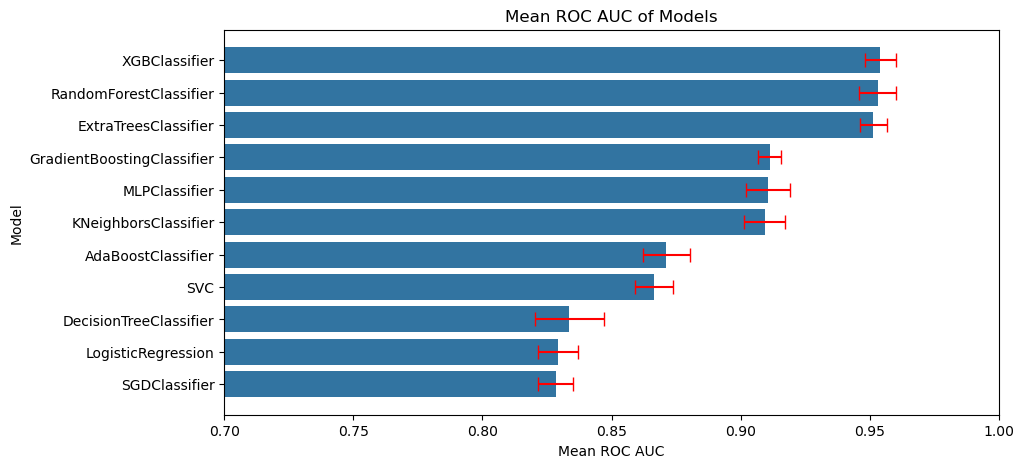

In [64]:
plt.figure(figsize=(10, 5))
sorted_models = cross_val_results.sort_values(by='mean_roc_auc', ascending=False)
sns.barplot(data=sorted_models, x="mean_roc_auc", y="model")
plt.errorbar(x=cross_val_results["mean_roc_auc"], y=cross_val_results["model"], xerr=cross_val_results["std_roc_auc"], fmt='none', ecolor='r', capsize=5)
plt.xlim(0.7, 1)
plt.xlabel("Mean ROC AUC")
plt.ylabel("Model")
plt.title("Mean ROC AUC of Models")
plt.show()


In [38]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

class ModelOptimizer:
    def __init__(self, classifier, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2):
        """
        Initializes the ModelOptimizer with a classifier, parameter grid, and other settings for GridSearchCV.
        
        Parameters:
        - classifier: The machine learning classifier to optimize.
        - param_grid: The hyperparameter grid to search over.
        - cv: The number of cross-validation folds.
        - scoring: The scoring method to use.
        - n_jobs: The number of jobs to run in parallel.
        - verbose: The verbosity level.
        """
        self.classifier = classifier
        self.param_grid = param_grid
        self.cv = cv
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.grid_search = None
        self.best_model = None

    def fit(self, X_train, y_train):
        """
        Fits the GridSearchCV to find the best hyperparameters and retrains the classifier on the entire training set.
        
        Parameters:
        - X_train: Training features.
        - y_train: Training labels.
        """
        self.grid_search = GridSearchCV(estimator=self.classifier, param_grid=self.param_grid,
                                        cv=self.cv, n_jobs=self.n_jobs, verbose=self.verbose,
                                        scoring=self.scoring)
        self.grid_search.fit(X_train, y_train)
        self.best_model = self.classifier.set_params(**self.grid_search.best_params_)
        self.best_model.fit(X_train, y_train)

    def evaluate(self, X_test, y_test):
        """
        Evaluates the best model on the test set and prints out various metrics.
        
        Parameters:
        - X_test: Test features.
        - y_test: Test labels.
        """
        y_pred = self.best_model.predict(X_test)
        roc_auc = roc_auc_score(y_test, y_pred)
        print(f"\n ROC AUC: {roc_auc}")
        
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot confusion matrix
        #1 means glass forming and corresponds to amorphous, 0 means non full glass forming.

        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=["Non-full glass", "Amorphous"]).plot(values_format='d', cmap='Blues')
        plt.show()

    def get_best_params(self):
        """
        Returns the best parameters found by GridSearchCV.
        """
        return self.grid_search.best_params_ if self.grid_search else None
    
    def shap_feature_importance(self, X_test):
        """
        Plots the SHAP feature importance for the best model.
        
        Parameters:
        - X_test: Test features.
        """
        
        import shap

        # Create Tree Explainer object that can calculate shap values
        explainer = shap.TreeExplainer(self.best_model)

        # Compute SHAP values
        shap_values = explainer.shap_values(X_test)

        # Summary plot
        shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
        #shap.force_plot(explainer.expected_value, shap_values, X_test.columns, link='logit', matplotlib=True)
        #shap.force_plot(explainer.expected_value, shap_values[932], X_input.iloc[932])

        return self.best_model
       



Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END

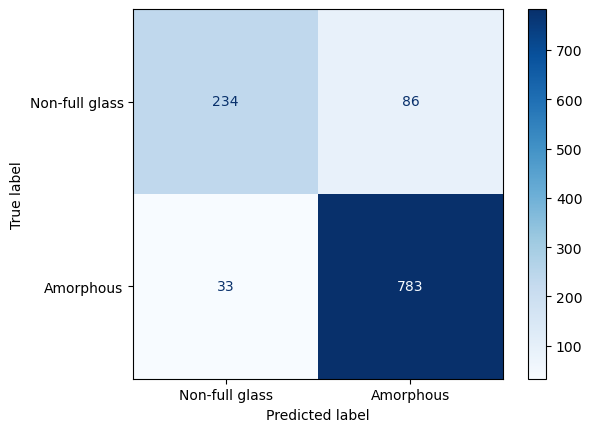

{'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [42]:
# Example classifier and parameter grid
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Split your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize, fit, and evaluate the model optimizer
model_optimizer = ModelOptimizer(classifier, param_grid)
model_optimizer.fit(X_train, y_train)
model_optimizer.evaluate(X_test, y_test)
print(model_optimizer.get_best_params())

warnings.filterwarnings('ignore')


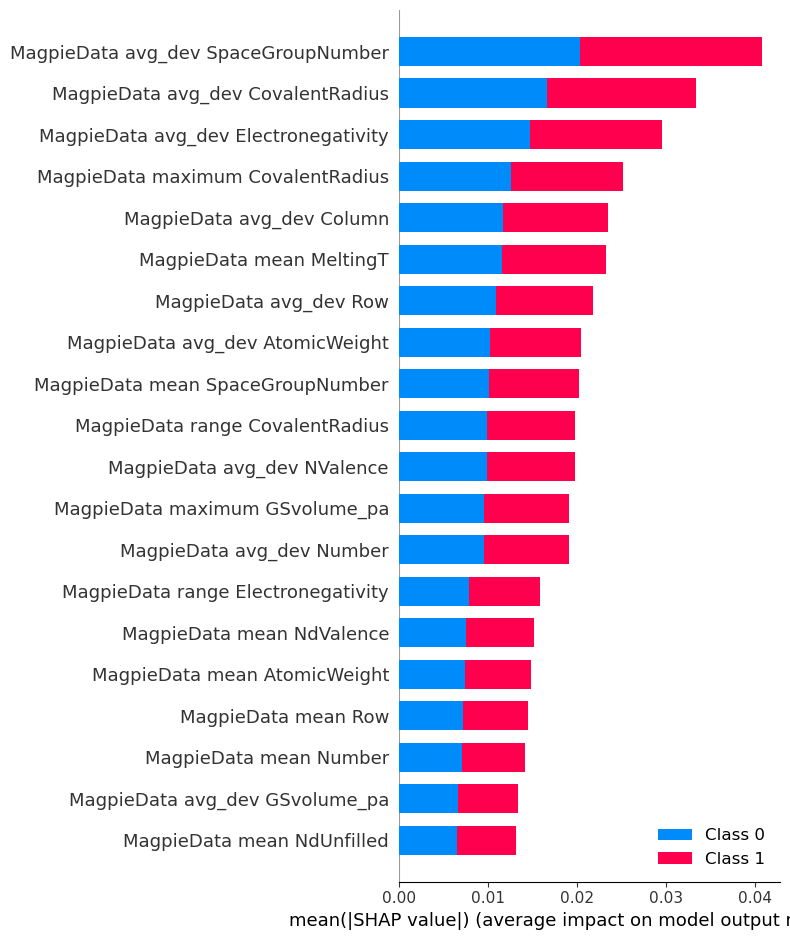

In [15]:
test_mod = model_optimizer.shap_feature_importance(X_test)


In [16]:



import shap

# Compute SHAP values for the first instance in the test set
shap_values_instance = explainer.shap_values(X_test.iloc[0])

# Get the expected value (this is the average model output over the training dataset)
expected_value = explainer.expected_value

# Create a force plot
shap.force_plot(expected_value[0], shap_values_instance[0], X_test.iloc[0])




NameError: name 'explainer' is not defined

In [ ]:
import warnings

explainer = shap.TreeExplainer(test_mod)
expected_value = explainer.expected_value
print(f"Explainer expected value: {expected_value}")
expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")


#if isinstance(expected_value, list):
#    expected_value = expected_value[1]
#    print("We are in the isinstance loop")
#print(f"Explainer expected value: {expected_value}")

#select 20 random instances from the test set
select = np.random.choice(X_test.index, 20, replace=False)
print(f"Selected instances: {select}")

features = X_test.loc[select]

#select = range(20)
#features = X_test.iloc[select]
#drop composition gfa composition_pmg from featurised_data so it is the same dimensions as X_test
plot_data = featurised_data.drop(columns=["gfa", "composition_pmg", "composition"])
features_display = plot_data.loc[features.index]



In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
    print(f"SHAP values shape: {shap_values.shape}")
    print(f"SHAP interaction values length: {len(shap_interaction_values)}")
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]
    print("We are in the isinstance loop")

In [ ]:
print("expected_value", expected_value)
print(f"SHAP values: {shap_values.shape}")
shap.decision_plot(expected_value, shap_values, plot_data, link='logit' , legend_labels = ['Non-full glass', 'Amorphous'])

In [ ]:
# pytorch neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau



# Set the batch size
batch_size = 64

# Convert data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    

# Check if MPS is available
if torch.backends.mps.is_available():
    # Set the device to MPS
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("MPS not available, using CPU")


# Create a neural network class for binary classification

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # Increase the number of neurons
        self.bn1 = nn.BatchNorm1d(64)  # Adjust to match the number of neurons
        self.dropout1 = nn.Dropout(0.3)  # Increase the dropout rate
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)  # Add a new layer
        self.dropout3 = nn.Dropout(0.3)  # Add a new layer
        self.fc4 = nn.Linear(16, 1)  # Add a new layer
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))  # Add a new layer
        x = self.dropout3(x)  # Add a new layer
        x = torch.sigmoid(self.fc4(x))  # Adjust to use the new layer
        return x
        
    
# Create an instance of the neural network
input_dim = X_train.shape[1]
print(f"Input dimension: {input_dim}")
model = NeuralNetwork(input_dim)

# Define the loss function and the optimizer
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
#learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min')

# Train the model
# Send the model to the device
model.to(device)

# Train the model
n_epochs = 30

training_losses = []
validation_losses = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    average_training_loss = running_loss / len(train_loader)
    training_losses.append(average_training_loss)
    
    # Evaluate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            
            val_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(test_loader)}")

    scheduler.step(val_loss) # Adjust the learning rate

    average_validation_loss = val_loss / len(test_loader)
    validation_losses.append(average_validation_loss)

plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Evaluate the model
model.eval()
y_pred = model(X_test_tensor.to(device)).detach().cpu().numpy()

# Convert the predictions to binary
y_pred = (y_pred > 0.5).astype(int)


# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {roc_auc}")



# Save the model
torch.save(model.state_dict(), "model.pth")

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


In [ ]:
Accuracy: 0.8327464788732394
ROC AUC: 0.7498681745257088

In [ ]:
# perform principal component analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

## Training and testing

Train, validate and test your model. Comment on the performance metrics. Note the best-performing model on the [MatBench](https://matbench.materialsproject.org) leaderboard.  With limited resources, don't expect to match this performance, but you should do better than a baseline model. 

<details>
<summary>Note on the ROC-AUC classification metric</summary>
There is one metric we didn't cover but is used in Matbench. In binary classification models, the ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) score can be used to evaluate performance. It quantifies the ability of the model to distinguish between positive and negative instances across different decision thresholds. A higher ROC-AUC score (ranging from 0.5 to 1) indicates better performance, with 1 representing a perfect classifier and 0.5 indicating performance no better than random chance. There is a more detailed discussion on https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc.

The metric can be calculated using the `roc_auc_score` function from the `sklearn.metrics` module, e.g.

```python
from sklearn.metrics import roc_auc_score

# Assuming you have true labels (y_true) and predicted probabilities (y_pred_prob) 
y_true = [...]  
y_pred_prob = [...]  

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_true, y_pred_prob)

# Display the result
print(f'ROC-AUC Score: {roc_auc:.4f}')
```
</details>

In [ ]:
# Spare cell




## Large Language Model (LLM) usage declaration

You should acknowledge any use of a generative model during your assignment. Points to consider:

* State which LLM (e.g. GPT-3, Gemini, Co-Pilot)

* Specify tasks (e.g. summarising research or code snippets)

* Were any limitations/biases noted?

* How did you ensure ethical use?

In [ ]:
# Spare cell




## ☘️ Final word

Good luck building your own model! I hope that you enjoyed the course and exercises. Dive deeper into the aspects that caught your interest. A useful starting point may be the [Resources](https://aronwalsh.github.io/MLforMaterials/Resources.html) page. 

Remember that submission is on Blackboard and this time you should upload the actual Juypter Notebook (`.ipynb` file), as well as your recorded narrated presentation (maximum 5 minutes; see guides on using [Zoom](https://www.youtube.com/watch?v=H9qhoAIzW3E) or [Powerpoint](https://www.youtube.com/watch?v=Y5dgwwa5XRA) for this purpose).